In [0]:
# Don't run if not running in Google Colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Pre-requisite to install before running the code

If you are installing any dependent libraries, please specify here as pre-req 
to install before running the notebook


1.   scikit-learn
2.   Keras


In [0]:
#run to install pre-req libraries
!pip install textstat
!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.21.3)


In [0]:
from datetime import datetime 
start_real = datetime.now()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydot_ng as pydot
from textstat import textstat
import dask.dataframe as dd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dropout, Dense, concatenate, GRU, Embedding, Flatten, Activation
from keras.optimizers import Adam
from keras.callbacks import History
from keras.models import Model
from keras.utils import plot_model
from keras import backend as K
from nltk.corpus import stopwords
import math
# set seed
np.random.seed(123)

Using TensorFlow backend.


### Store the dataset

In [0]:
# Input data files are available in the "../mercari-price-suggestion-challenge/" directory.
# NOTE: Please modify the absolute path before /mercari-price-suggestion-challenge accordingly

# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the mercari-price-suggestion-challenge directory

import os
print(os.listdir("/content/gdrive/My Drive/DMT/mercari-price-suggestion-challenge"))
input_folder = '/content/gdrive/My Drive/DMT/mercari-price-suggestion-challenge/'

# Any results you write to the current directory are saved as output.

['sample_submission.csv.7z', 'sample_submission_stg2.csv', 'train.tsv', 'test.tsv', 'train.pkl', 'wiki.en.bin.bin', 'model.best.weights.hdf5', 'train_word2vec.pkl', 'model.png', 'dumps', 'model_word2vec.best.weights.hdf5', 'val_xgboost.pkl', 'test_xgboost.pkl', 'train_xgboost.pkl']


## 1. Data Preprocesing

In [0]:
# Load saved preprocessed data
processed_train_data = pd.read_pickle(input_folder + 'dumps/train_data.pkl')
processed_val_data = pd.read_pickle(input_folder + 'dumps/validation_data.pkl')
processed_test_data = pd.read_pickle(input_folder + 'dumps/test_data.pkl')

In [0]:
train_df = processed_train_data.copy()
dev_df = processed_val_data.copy()
test_df = processed_test_data.copy()

In [0]:
n_trains = train_df.shape[0]
n_devs = dev_df.shape[0]
n_tests = test_df.shape[0]
print("Training on", n_trains, "examples")
print("Validating on", n_devs, "examples")
print("Testing on", n_tests, "examples")

Training on 1333492 examples
Validating on 74083 examples
Testing on 74083 examples




### Convert Categorical features into continuous features


The columns name: category, cat_1, cat_2, cat_3 and brand_name have categorical values. Categorical values can be converted to One Hot Encoding to feed into a machine learning model. 

In [0]:
import bisect


def label_encoding(col):
  le = LabelEncoder()
  train_df[col] = train_df[col].astype(str)
  le.fit(train_df[col])

  le_classes = le.classes_.tolist()
  bisect.insort_left(le_classes, '<unknown>')
  le.classes_ = le_classes
  #transform on train data
  train_df[col] = le.transform(train_df[col])
  #transform on test data
  test_df[col] = test_df[col].map(lambda s: '<unknown>' if s not in le.classes_ else s)
  test_df[col] = le.transform(test_df[col])
  #transform on dev data
  dev_df[col] = dev_df[col].map(lambda s: '<unknown>' if s not in le.classes_ else s)
  dev_df[col] = le.transform(dev_df[col])
  
  del le
  return train_df[col], test_df[col], dev_df[col]

In [0]:
%%time

train_df['category'] = train_df.category_name
test_df['category'] = test_df.category_name
dev_df['category'] = dev_df.category_name

train_df['category'],test_df['category'], dev_df['category']= label_encoding('category')
train_df['cat_1'],test_df['cat_1'], dev_df['cat_1'] = label_encoding('cat_1')
train_df['cat_2'],test_df['cat_2'], dev_df['cat_2'] = label_encoding('cat_2')
train_df['cat_3'],test_df['cat_3'], dev_df['cat_3'] = label_encoding('cat_3')

CPU times: user 5.32 s, sys: 52.2 ms, total: 5.37 s
Wall time: 5.37 s


### Process text data


In [0]:

%%time

print("Transforming text data to sequences...")
raw_text = np.hstack([train_df.item_description.str.lower(), train_df.name.str.lower(), train_df.category_name.str.lower()])

print("   Fitting tokenizer...")
tok_raw = Tokenizer()
tok_raw.fit_on_texts(raw_text)

print("   Transforming text to sequences...")
train_df['seq_item_description'] = tok_raw.texts_to_sequences(train_df.item_description.str.lower())
train_df['seq_name'] = tok_raw.texts_to_sequences(train_df.name.str.lower())

test_df['seq_item_description'] = tok_raw.texts_to_sequences(test_df.item_description.str.lower())
test_df['seq_name'] = tok_raw.texts_to_sequences(test_df.name.str.lower())

dev_df['seq_item_description'] = tok_raw.texts_to_sequences(dev_df.item_description.str.lower())
dev_df['seq_name'] = tok_raw.texts_to_sequences(dev_df.name.str.lower())

del tok_raw

Transforming text data to sequences...
   Fitting tokenizer...
   Transforming text to sequences...
CPU times: user 2min 47s, sys: 1.33 s, total: 2min 48s
Wall time: 2min 48s


In [0]:
train_df['seq_name'][:5]

958469           [513, 1916, 61, 729, 61]
693778       [145, 3746, 1465, 779, 2070]
210050                 [61, 906, 283, 61]
447294     [5012, 71420, 319, 1546, 1271]
1480041           [1728, 2155, 821, 1973]
Name: seq_name, dtype: object

#### constants

In [0]:
MAX_NAME_SEQ = 10 #17
MAX_ITEM_DESC_SEQ = 75 #269
MAX_CATEGORY_SEQ = 8
MAX_TEXT = np.max([
    np.max(train_df.seq_name.max()),
    np.max(train_df.seq_item_description.max()),
#     np.max(train_df.seq_category.max()),
]) + 100
MAX_CATEGORY = np.max(train_df.category.max()) + 1
MAX_DESC_LEN = int(np.max(train_df.desc_len.max()) + 1)
MAX_NAME_LEN = int(np.max(train_df.name_len.max()) + 1)
MAX_CAT_1 = np.max(train_df.cat_1.max()) + 1
MAX_CAT_2 = np.max(train_df.cat_2.max()) + 1
MAX_CAT_3 = np.max(train_df.cat_3.max()) + 1


print(MAX_CATEGORY)
print(MAX_TEXT)
print(MAX_DESC_LEN)
print(MAX_NAME_LEN)
print(MAX_CAT_1)
print(MAX_CAT_2)
print(MAX_CAT_3)

1281
244455
246
18
12
115
872


In [0]:
## GET DATA FOR RNN

%%time

def get_rnn_data(dataset):
    X = {
        'name': pad_sequences(dataset.seq_name, maxlen=MAX_NAME_SEQ),
        'item_desc': pad_sequences(dataset.seq_item_description, maxlen=MAX_ITEM_DESC_SEQ),
        'category': np.array(dataset.category),
#         'category_name': pad_sequences(dataset.seq_category, maxlen=MAX_CATEGORY_SEQ),
#         'item_condition': np.array(dataset.item_condition_id),
        'shipping': np.array(dataset[["shipping"]]),
        'desc_len': np.array(dataset[["desc_len"]]),
        'name_len': np.array(dataset[["name_len"]]),
        'cat_1': np.array(dataset.cat_1),
        'cat_2': np.array(dataset.cat_2),
        'cat_3': np.array(dataset.cat_3),
        'item_condition_id_1': np.array(dataset.item_condition_id_1),
        'item_condition_id_2': np.array(dataset.item_condition_id_2),
        'item_condition_id_3': np.array(dataset.item_condition_id_3),
        'item_condition_id_4': np.array(dataset.item_condition_id_4),
        'item_condition_id_5': np.array(dataset.item_condition_id_5),
        'item_description_readability_score': np.array(dataset.item_description_readability_score),
    }
    return X


X_train = get_rnn_data(train_df)
Y_train = train_df.price.values.reshape(-1, 1)

X_dev = get_rnn_data(dev_df)
Y_dev = dev_df.price.values.reshape(-1, 1)

X_test = get_rnn_data(test_df)
Y_test = test_df.price.values.reshape(-1, 1)

CPU times: user 15.7 s, sys: 355 ms, total: 16 s
Wall time: 16 s


In [0]:
features = ['seq_name','category','seq_item_description',
            'desc_len','name_len','shipping','cat_1','cat_2','cat_3','item_description_readability_score','item_condition_id_1',
            'item_condition_id_2','item_condition_id_3','item_condition_id_4','item_condition_id_5','price']


train_df[features].head()

,seq_name,category,seq_item_description,desc_len,name_len,shipping,cat_1,cat_2,cat_3,item_description_readability_score,item_condition_id_1,item_condition_id_2,item_condition_id_3,item_condition_id_4,item_condition_id_5,price
958469,"[513, 1916, 61, 729, 61]",697,"[15, 2024, 34, 729, 3077, 1, 177, 4178, 5, 463...",47,5,1,6,6,438,6.34,0,1,0,0,0,-0.305263
693778,"[145, 3746, 1465, 779, 2070]",731,"[49, 18, 705, 682, 709, 99]",6,5,0,6,58,189,9.07,0,0,1,0,0,-0.227319
210050,"[61, 906, 283, 61]",1232,"[82, 7, 94, 1059, 127, 906, 283, 184, 18, 52, ...",22,4,1,10,97,410,5.84,0,1,0,0,0,-0.045449
447294,"[5012, 71420, 319, 1546, 1271]",1278,"[16, 6, 46, 38, 117, 18]",6,5,1,10,112,695,9.07,1,0,0,0,0,-0.071430
1480041,"[1728, 2155, 821, 1973]",3,"[27, 11, 3, 6, 82, 475, 2220, 1111, 1, 5860, 1...",120,5,1,1,10,191,11.99,1,0,0,0,0,-0.357226


## 4. Data modeling

In [0]:
def rmsle(y_true, y_pred):
    assert K.int_shape(y_true)[0] == K.int_shape(y_pred)[0]
    return K.sqrt(K.mean(K.square(K.log(y_pred+1) - K.log(y_true+1))))

### RNN Model

This section will use RNN Model to solve the competition with following steps:

1. Build RNN model
1. Fitting RNN model on training data


### BUILD RNN MODEL

In [0]:
# set seed again in case testing models adjustments by looping next 2 blocks
np.random.seed(123)

def new_rnn_model(lr=0.001, decay=0.0):
  
    # Passing Features from dataset into Input Layer
    name = Input(shape=[X_train["name"].shape[1]], name="name")
    item_desc = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")

#     item_condition = Input(shape=[1], name="item_condition")
    item_condition_id_1 = Input(shape=[1], name="item_condition_id_1")
    item_condition_id_2 = Input(shape=[1], name="item_condition_id_2")
    item_condition_id_3 = Input(shape=[1], name="item_condition_id_3")
    item_condition_id_4 = Input(shape=[1], name="item_condition_id_4")
    item_condition_id_5 = Input(shape=[1], name="item_condition_id_5")
    item_description_readability_score = Input(shape=[1], name="item_description_readability_score") 
    
    shipping = Input(shape=[X_train["shipping"].shape[1]], name="shipping")
    desc_len = Input(shape=[1], name="desc_len")
    name_len = Input(shape=[1], name="name_len")
    cat_1    = Input(shape=[1], name="cat_1")
    cat_2    = Input(shape=[1], name="cat_2")
    cat_3    = Input(shape=[1], name="cat_3")
    
    
    # Embeddings layers
    emb_name = Embedding(MAX_TEXT, 20)(name)
    emb_item_desc = Embedding(MAX_TEXT, 60)(item_desc)
    
    #emb_item_condition = Embedding(MAX_CONDITION, 5)(item_condition)
    emb_desc_len = Embedding(MAX_DESC_LEN, 5)(desc_len)
    emb_name_len = Embedding(MAX_NAME_LEN, 5)(name_len)
    emb_cat_1 = Embedding(MAX_CAT_1, 10)(cat_1)
    emb_cat_2 = Embedding(MAX_CAT_2, 10)(cat_2)
    emb_cat_3 = Embedding(MAX_CAT_3, 10)(cat_3)
    

    # rnn layers (GRUs are faster than LSTMs)
    rnn_layer1 = GRU(16) (emb_item_desc)
    rnn_layer2 = GRU(8) (emb_name)


    # main layers
    main_l = concatenate([
#         Flatten() (emb_item_condition),
#         , Flatten() (emb_category)
#         ,Flatten() (emb_brand_name)
        Flatten() (emb_desc_len)
        , Flatten() (emb_name_len)
        , Flatten() (emb_cat_1)
        , Flatten() (emb_cat_2)
        , Flatten() (emb_cat_3)
        , rnn_layer1
        , rnn_layer2
        , shipping
        , item_condition_id_1
        , item_condition_id_2
        , item_condition_id_3
        , item_condition_id_4
        , item_condition_id_5
        , item_description_readability_score
    ])

    main_l = Dropout(0.1)(Dense(512,kernel_initializer='normal',activation='relu') (main_l))
    main_l = Dropout(0.1)(Dense(256,kernel_initializer='normal',activation='relu') (main_l))
    main_l = Dropout(0.1)(Dense(128,kernel_initializer='normal',activation='relu') (main_l))
    main_l = Dropout(0.1)(Dense(64,kernel_initializer='normal',activation='relu') (main_l))

    # the output layer.
    output = Dense(1, activation="linear") (main_l)


    model = Model([name, item_desc, item_condition_id_1,item_condition_id_2,item_condition_id_3,item_condition_id_4,item_condition_id_5, 
                   shipping, desc_len, name_len, cat_1, cat_2, cat_3, item_description_readability_score], output)
  
    optimizer = Adam(lr=lr, decay=decay)
 
    model.compile(loss = 'mse', optimizer = optimizer)

    return model

model = new_rnn_model()
model.summary()

W0808 20:11:48.810801 140520030812032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0808 20:11:48.840131 140520030812032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0808 20:11:48.842005 140520030812032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0808 20:11:49.333421 140520030812032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0808 20:11:49.349936 140520030812032 deprecation_wra

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
desc_len (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
name_len (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
cat_1 (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
cat_2 (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
cat_3 (Inp

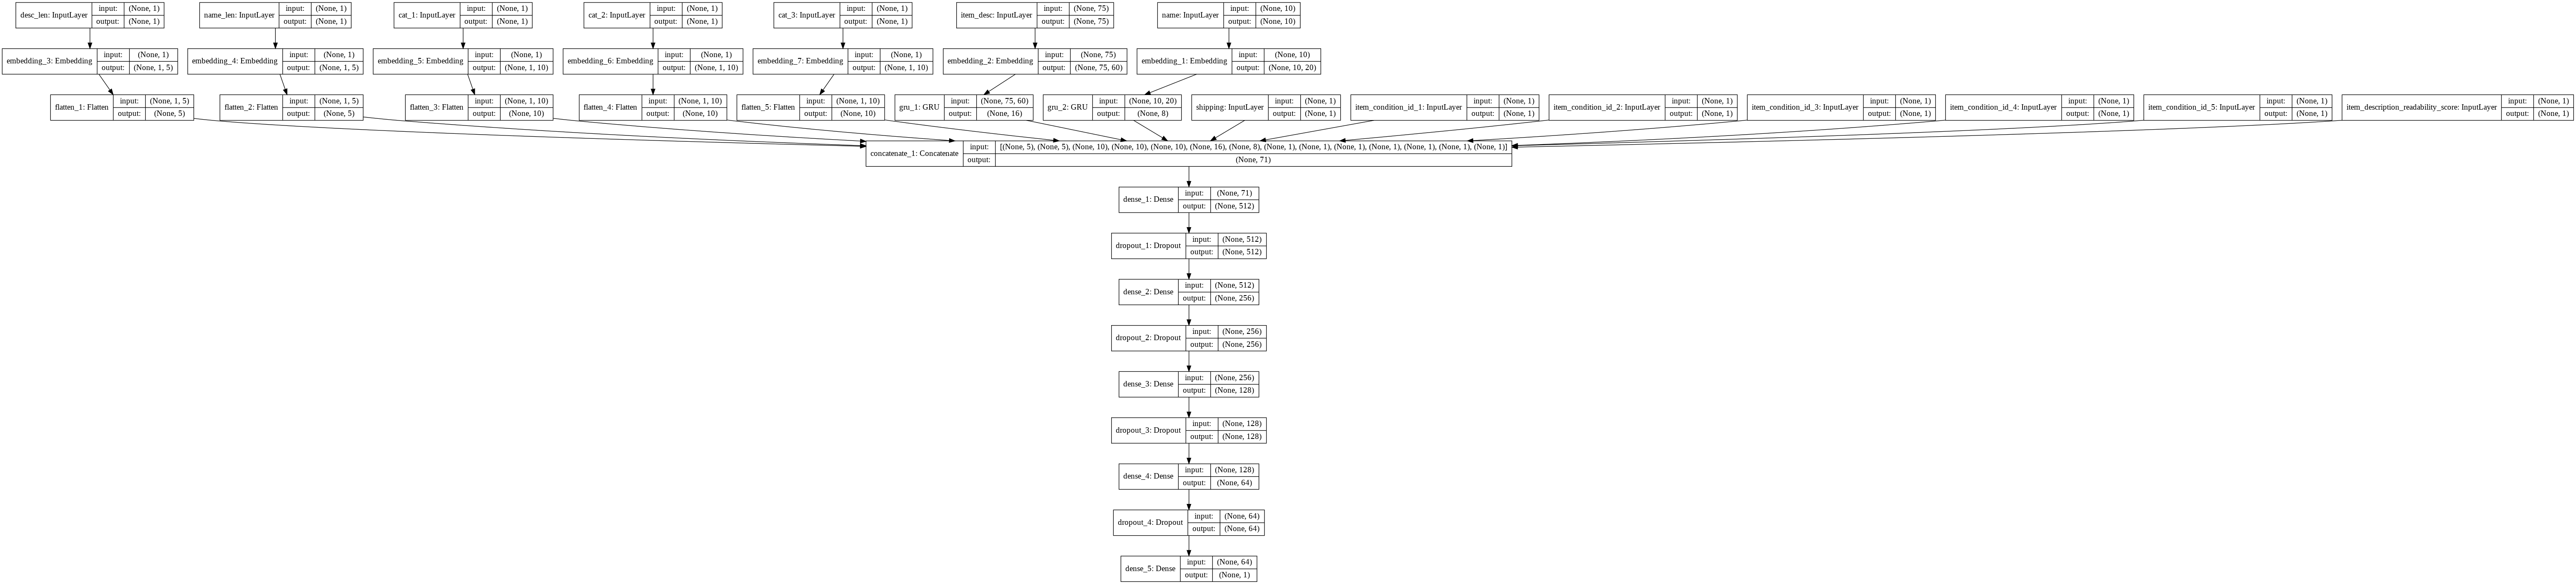

In [0]:
#display model architecture
import pydot_ng as pydot
plot_model(model, show_shapes=True, show_layer_names=True, to_file= input_folder + 'rnn_model.png')
from IPython.display import Image
Image(retina=True, filename=input_folder + 'model.png')

In [0]:
del model

### Fitting RNN model to train data

keeping 2 epochs with smaller batches tends to do better than more epochs with larger batches

In [0]:
history = History()

callbacks = [history]

In [0]:
%%time

# Set hyper parameters for the model.
BATCH_SIZE = 512 * 3
epochs = 2

# Calculate learning rate decay.
exp_decay = lambda init, fin, steps: (init/fin)**(1/(steps-1)) - 1
steps = int(len(X_train['name']) / BATCH_SIZE) * epochs
lr_init, lr_fin = 0.005, 0.001
lr_decay = exp_decay(lr_init, lr_fin, steps)




# Create model and fit it with training dataset.
rnn_model = new_rnn_model(lr=lr_init, decay=lr_decay)
history  =  rnn_model.fit(
        X_train, Y_train, epochs=epochs, batch_size=BATCH_SIZE,
        validation_data=(X_dev, Y_dev), verbose=1, callbacks=callbacks
)

W0808 20:11:51.943603 140520030812032 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1333492 samples, validate on 74083 samples
Epoch 1/2
1333492/1333492 [==============================] - 163s 122us/step - loss: 0.5721 - val_loss: 0.4301
Epoch 2/2
1333492/1333492 [==============================] - 160s 120us/step - loss: 0.4042 - val_loss: 0.4088
CPU times: user 7min 59s, sys: 1min 30s, total: 9min 30s
Wall time: 5min 26s


## 5.  Evaluation

1. Evaluating RNN model
1. Make prediction for test data using RNN model

### RMSL Error Helper Function

In [0]:
# def rmsle(Y, Y_pred):
#     assert Y.shape == Y_pred.shape
#     return np.sqrt(np.mean(np.square(Y_pred - Y )))

def rmsle(y_true, y_pred):
    assert y_true.shape == y_pred.shape
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

 ### Evaluate RNN model on dev data

In [0]:
%%time

print("Evaluating the model on validation data...")
y_pred = rnn_model.predict(X_dev, batch_size=BATCH_SIZE)
print(" RMSLE Validation error:", rmsle(Y_dev, y_pred))

Evaluating the model on validation data...
 RMSLE Validation error: 0.33794264996734025
CPU times: user 5.27 s, sys: 820 ms, total: 6.09 s
Wall time: 3.36 s


Hypertuning parameter to improve validation error

### Evaluate RNN model on test data

In [0]:
%%time
Y_test = test_df.price.values.reshape(-1, 1)
print("Evaluating the model on test data...")
y_test_pred = rnn_model.predict(X_test, batch_size=BATCH_SIZE, verbose=1)
print(" RMSLE test error:", rmsle(Y_test, y_test_pred))


Evaluating the model on test data...
74083/74083 [==============================] - 3s 41us/step
 RMSLE test error: 0.33659991547614904
CPU times: user 4.94 s, sys: 862 ms, total: 5.81 s
Wall time: 3.03 s
